## Business Problem

The number of Credit Card Users for Thera Bank is declining. Credit cards are a good source of income for Thera Bank because of different kinds of fees charged by the banks. Customers’ leaving credit cards services is a serious concern for Thera Bank.

Since Customer churning is a major issue for There Bank, the business problem for Thera Bank is to predict churning customers and find levers or areas that would help improve its services to Credit Card customers.  Improved customer service will hopefully help reduce the churn and the loss due to churning customers. 


## Machine Learning Solution

The above business problem of Thera Bank can be translated into a Supervised Machine Learning Classification problem. The data is already provided by the bank. Based on the available data, in this case, the purpose of the classification model is to:
-	predict credit card customers who would leave/ churn
-	find top reasons or features that are responsible for customers to churn

To build a high performing classification model which generalizes well and is not underfitting or overfitting, the model should:

-	be built by experimenting with different classifier estimators, including Logistic Regression, Bagging and Boosting Algorithms based estimators
-	consider suitable oversampling & undersampling techniques to account for imbalanced data
-	tune the estimators by selecting suitable hyper parameters applied through RandomizedCV

The model comparison & selection will be done on the metric that would minimize business loss most pertinent for this case. There are 2 types of losses for Thera Bank in this case - assuming the classifier predicts - Churn (Yes/ No)

1.	FP - If a customer was predicted to be churning, but he stays! There is a minimal loss of resource in this case for the bank
2.	FN – If a customer was predicted not to be churning, but he churns!  This is a major revenue loss for the bank and these cases must be minimized

Overall, the main purpose of the model is to predict customers who would churn, so for Thera Bank is also crucial to have a model that predicts strong TP.

So, for the calssiffication model, the optimization objective is {maximize TP, minimize FN}. Hence, we shall use Recall as the most suitable metric for comparing and selecting the model.

Finally, the data preprocessing & transformation along with selected model and its hyperparameters will be all packaged with Pipeline to automate preprocessing, transform & fit and make the model production ready.


## Solution Approach
1. Loading the libraries and csv
2. Checking the shape, size, missing values etc. for data
3. Preprocessing & EDA
    - Univariate Analysis
    - Bivariate  & Multivariate Analysis
4. Data Preparation and Feature Engineering'
5. Model Building
    - Model evaluation criteria
6. Model building - Imbalanced Data
7. Model building - Oversampled data
8. Model building - Undersampled data
9. Hyperparameter tuning using RandomizedSearchCV
    - Comparing Model Performances
	- Selecting the final model tuned by GridSearchCV
10. Productionizing the model using Pipelines
11. Actionable Insights and Recommendations

In [1]:
# Load the libraries and data file
# To help with reading and manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

#supress warnings
import warnings
warnings.filterwarnings("ignore")



In [2]:
#load data
data = pd.read_csv('BankChurners.csv')

In [3]:
# take a copy of the original data;
df = data.copy()

In [4]:
# function for total count of missing values as well as percentage of missing values 

def missing_values(df):
    missing = df.isna().sum()
    percent_missing = round(df.isna().mean()*100,2) 
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'missing': missing,
                                 'percent_missing': percent_missing}).reset_index(drop = True)
    return missing_value_df


# function for printing value counts (incl NaN) for categorical columns
def get_value_counts(df):
    obj_cols = df.select_dtypes(include = ['object', 'category']).columns.to_list()
    for idx, col in enumerate(obj_cols):
        print(df[col].value_counts(dropna = False))
        print('*'*25)

In [5]:
# to start with, read a sample of data from the dataframe
df.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1052,720650208,Existing Customer,40,F,3,College,NaN,$40K - $60K,Blue,22,3,3,3,12588.0,2005,10583.0,0.996,1561,26,1.000,0.159
8081,784880958,Existing Customer,34,F,4,Graduate,Single,$40K - $60K,Blue,28,2,3,1,4022.0,1680,2342.0,0.579,3776,84,0.826,0.418
9223,719593608,Attrited Customer,56,M,1,Uneducated,Married,$80K - $120K,Blue,36,6,2,1,33870.0,0,33870.0,0.872,7661,61,0.525,0.000
6642,709938708,Existing Customer,56,F,3,Uneducated,Married,abc,Blue,47,4,1,2,1822.0,1118,704.0,0.896,4576,78,0.529,0.614
7023,716791908,Existing Customer,43,M,1,College,Married,$80K - $120K,Blue,23,5,2,1,14566.0,1045,13521.0,0.417,4480,77,0.791,0.072


In [6]:
# check the shape and structure of the data
num_cols = df.select_dtypes(include = np.number).columns.to_list()
cat_cols = df.select_dtypes(exclude = np.number).columns.to_list()
print(df.shape)
print(f'Num of numerical cols:{len(num_cols)} Num of Categorical cols: {len(cat_cols)}')
print('*'*50)
df.info()
print('*'*50)
# check whether there's any duplicated rows
print(f'Num of duplicated rows: {df.duplicated().sum()}')

(10127, 21)
Num of numerical cols:15 Num of Categorical cols: 6
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  C

### Observation from df.shape and df.info()
- There are 10127 rows and 21 cols
- Out of 21, 15 are numerical and 6 are categorical columns
- At the first look at it, only Education_Level and Marital_status seem to have missing values
    - we shall impute all missing values after splitting the data into train, validation and test datasets
- There are no duplicated rows

In [7]:
#first check the duplicated rows
df.duplicated().sum()

0

In [8]:
# lets quickly check missing values; all columns where missing values > 0
nullseries = df.isna().sum()
nullseries[nullseries > 0]


Education_Level    1519
Marital_Status      749
dtype: int64

In [9]:
# lets check missing values in detail now, including percentage missing
missing_values(df)

,column_name,missing,percent_missing
0,CLIENTNUM,0,0.0
1,Attrition_Flag,0,0.0
2,Customer_Age,0,0.0
3,Gender,0,0.0
4,Dependent_count,0,0.0
5,Education_Level,1519,15.0
6,Marital_Status,749,7.4
7,Income_Category,0,0.0
8,Card_Category,0,0.0
9,Months_on_book,0,0.0


### Missing values observation
- 15% (1519 rows) of Education_Level is missing
- 7.4% (749 rows) of Marital_status is missing
- we shall impute all missing values after splitting the data into train, validation and test datasets

# Data Preprocessing & EDA

### Observing Categorical Features

In [10]:
# before going further lets drop CLIENTNUM as this a ID kind of column having all rows as unique values
df = df.drop('CLIENTNUM', axis = 1)

In [11]:
# lets check categorical variables now; start with the dependent variable
print(df['Attrition_Flag'].value_counts(normalize = True))


Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64


- we can see that we've a imbalanced dataset with 84% as Existing Customer, and only 16% as Attrited Customer

In [12]:
# lets convert Existing Customer = 0 and Attrited Customer = 1 in Attrition_Flag columns
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1 })

In [13]:
# lets check categorical variables now; start with the dependent variable
print(df['Attrition_Flag'].value_counts(normalize = True))
print('*'*25)
# now lets print different categories for categorical features and their counts
get_value_counts(df)

0    0.83934
1    0.16066
Name: Attrition_Flag, dtype: float64
*************************
F    5358
M    4769
Name: Gender, dtype: int64
*************************
Graduate         3128
High School      2013
NaN              1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
*************************
Married     4687
Single      3943
NaN          749
Divorced     748
Name: Marital_Status, dtype: int64
*************************
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
*************************
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64
*************************


In [14]:
# lets also include Dependent_count, since they seem to be categorical at first
print(df['Dependent_count'].value_counts())



3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64


In [15]:
# since they only take few discrete values
#lets change Dependent_Count to Categoricals features for One Hot Encoding(OHE)
df['Dependent_count']= df['Dependent_count'].astype('category')

In [16]:
# check the shape, dtypes and organization of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  int64   
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  object  
 3   Dependent_count           10127 non-null  category
 4   Education_Level           8608 non-null   object  
 5   Marital_Status            9378 non-null   object  
 6   Income_Category           10127 non-null  object  
 7   Card_Category             10127 non-null  object  
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

### Value Count Observations for categorical features
- The dependent variable is highly imbalanced with almost 84% as 'Existing Customer' and 16% as 'Attrited Customer' categories
- Education_LeveL has quite many categories but also 1519 missing values. 'Graduate' is the highest and 'Doctorate' is the least occuring category
    - we shall impute the missing with the most_freuent, i.e. Graduate; to be checked more
- Marital_Status has ['Married', 'Single', 'Divorced'] categories but also 749 missing values. 'Married' is the leading and 'Divorced' is the least occuring category
    - we shall impute the missing with the most_freuent; to be checked more
- 'Less than 40K ' is the leading category and '$120k+' is the least occuring category in Income_Category
    - also, there are 1112 values as 'abc' which we shall treat it as missing values
    - like said above, we shall impute all missing values after splitting the data into train, validation and test datasets
- Card_category has ['Blue', 'Silver','Gold','Platinum'] categories. 'Blue' and 'Platinum' are the highest and least occuring categories

## 5- pt Summary for Numerical features

In [17]:
# let's view the statistical summary of the numerical columns in the data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
Customer_Age,10127.00,46.33,8.02,26.00,41.00,46.00,52.00,73.00
Months_on_book,10127.00,35.93,7.99,13.00,31.00,36.00,40.00,56.00
Total_Relationship_Count,10127.00,3.81,1.55,1.00,3.00,4.00,5.00,6.00
Months_Inactive_12_mon,10127.00,2.34,1.01,0.00,2.00,2.00,3.00,6.00
Contacts_Count_12_mon,10127.00,2.46,1.11,0.00,2.00,2.00,3.00,6.00
Credit_Limit,10127.00,8631.95,9088.78,1438.30,2555.00,4549.00,11067.50,34516.00
Total_Revolving_Bal,10127.00,1162.81,814.99,0.00,359.00,1276.00,1784.00,2517.00
Avg_Open_To_Buy,10127.00,7469.14,9090.69,3.00,1324.50,3474.00,9859.00,34516.00
Total_Amt_Chng_Q4_Q1,10127.00,0.76,0.22,0.00,0.63,0.74,0.86,3.40


### Observation from 5 pt summary of numerical columns
- Customer_Age looks pretty unskewed distribution with both Mean & Median as 46. Most Customer_Age [between 1st & 3rd quartile] fall into 41 - 52 range. Min Customer_Age is 26 and Max is 73
- Months_on_book also looks pretty unskewed distribution with both Mean & Median as 36. Most Months_on_book [between 1st & 3rd quartile] fall into 31 - 40 range. Min & Max values are 13 & 56 respectively
- Total_Relationship_Count has discrte values, min 1 and max 6 with median of 4
- Months_Inactive_12_mon also have discrete values with min & max as 0 & 6. The mean & median are 2.34 & 2 respectively
- Contacts_Count_12_mon also have discrete values with min & max as 0 & 6. The mean & median are 2.46 & 2 respectively
- Credit_Limit is a highly right skewed distribution. Mean is 8631.95 while median is 4549. The Max 34516 can be considered as Outlier
    - While outlier could be a perfectly normal case where some customers have exceedingly high credit limit, we shall apply RobustScaler to scale this column
- Total_Revolving_Bal has min as 0, max as 2517, and median 1276 and mean 1162.81. 
- Avg_Open_To_Buy is a right skewed distribution with mean and median as 7469.14 and 3474
- Total_Amt_Chng_Q4_Q1 provides ratio and it ranges from 0 - 3.40
- Total_Ct_Chng_Q4_Q1 provides ratio and it ranges from 0 - 3.71
- Total_Trans_Amt is a right skewed distribution with mean and median as 4404.9 and 3899
- Total_Trans_Ct ranges from 10 - 139, with mean and median as 64.86 and 67
- Avg_Utilization_Ratio varies from 0 to 1, with mean and median as 0.27 and 0.18
    


# Univariate Analysis

<AxesSubplot:ylabel='Attrition_Flag'>

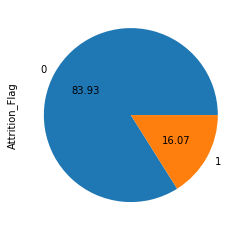

In [18]:
# let's start with the dependent value
# Piechart to visually show our imbalanced data
df['Attrition_Flag'].value_counts().plot(kind = 'pie', autopct = '%.2f')

In [19]:
#let's write some functions for plots

def hb(data, feature, figsize=(12, 7), kde=False, bins=None):
    # boxplot + histogram
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="gray"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    
def sb(data, predictor, target):
    # draws stacked barplot

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, 
             #figsize=(count + 1, 5))
             figsize=(10,5))
    
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

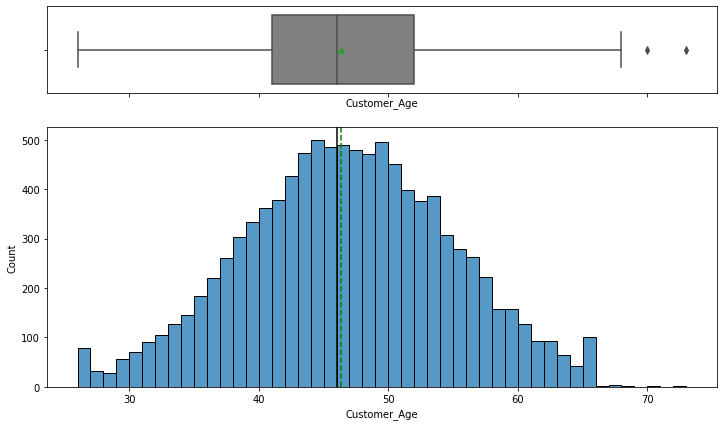

In [20]:
# draw box-plot and hitogram of numerical col
hb(df, 'Customer_Age')

- the distribution is symmetric, though there are some outliers, but we will not remove or impute them since age can naturally have large numbers

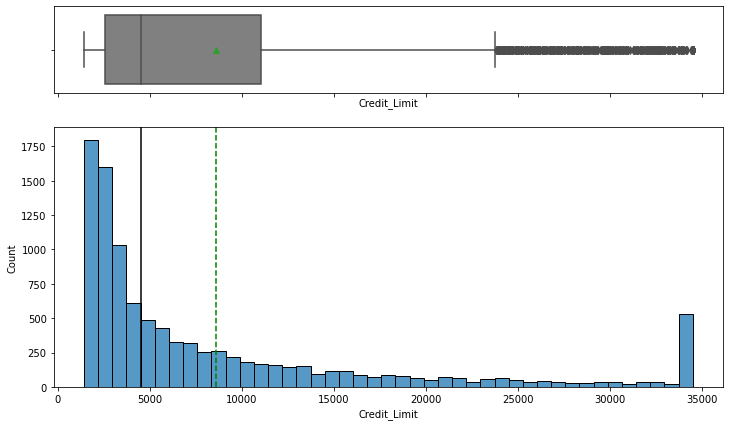

In [21]:
# draw box-plot and hitogram of numerical col
hb(df,'Credit_Limit')

- the distribution is right skewed; there are outliers but we will not remove or impute them since those could be valid data points in this case
- the values are in thousands, so we'll cover that through Scaling (Standard Scaler)

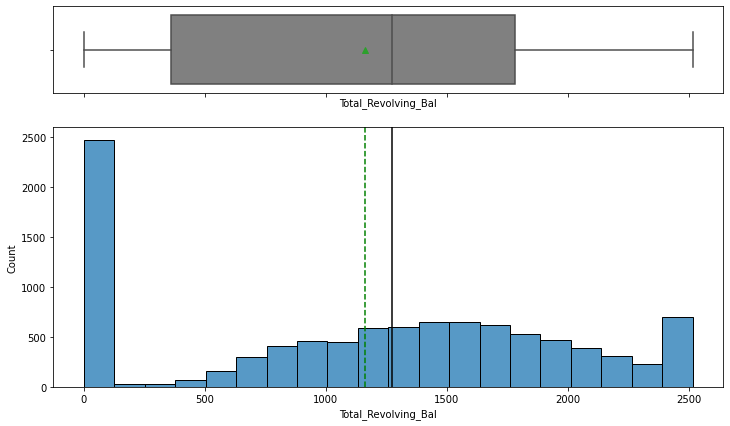

In [22]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Revolving_Bal')

- the distribution is left skewed with high frequency of occurence near 0

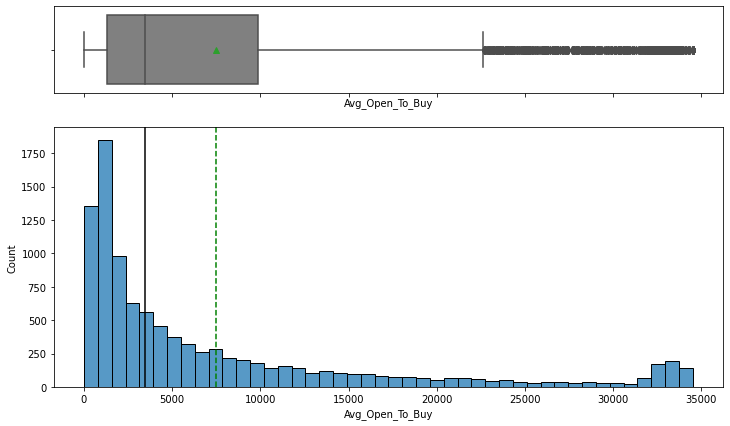

In [23]:
# draw box-plot and hitogram of numerical col
hb(df,'Avg_Open_To_Buy')

- the distribution is right skewed with outliers on the right, but we shall not remove or impute those since they may represnt valid data points in this case
- the values are in thousands, scaling may be needed

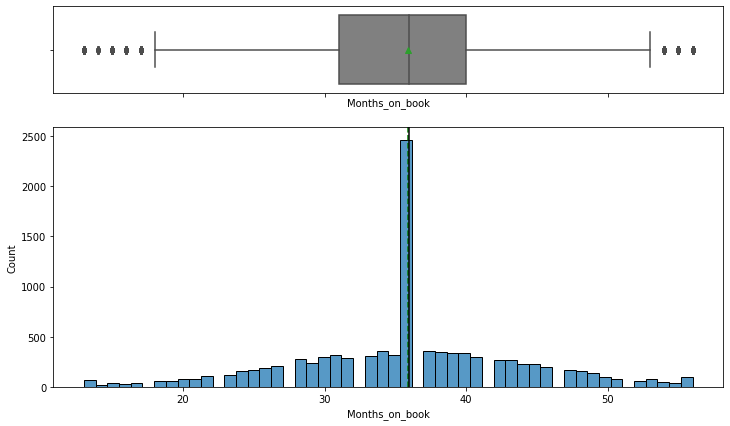

In [24]:
# draw box-plot and hitogram of numerical col
hb(df, 'Months_on_book')

- the distribution is pretty symmetric with mean & median both atr around 36

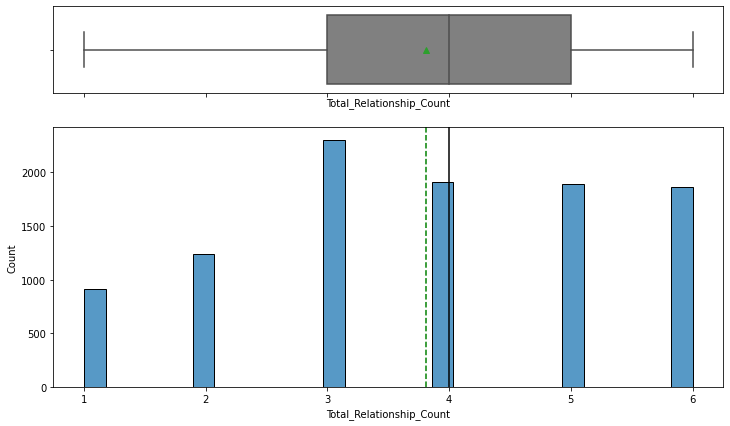

In [25]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Relationship_Count')

- Total_Relationship_Count has only discrete values with 3 has highest frequency; 1 & 6 as min & max

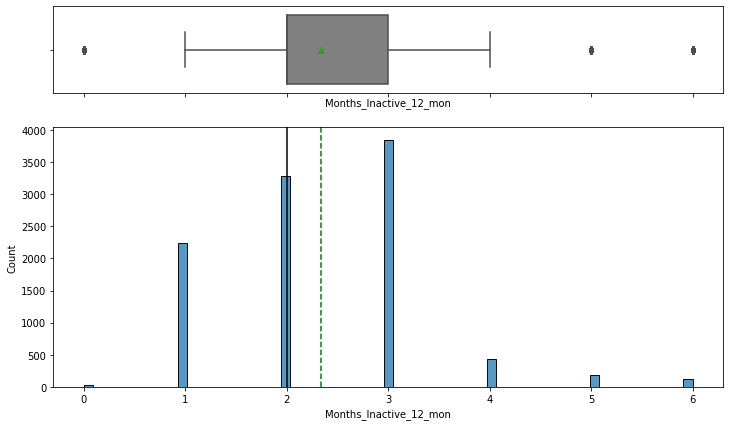

In [26]:
# draw box-plot and hitogram of numerical col
hb(df,'Months_Inactive_12_mon')

- discrete distribution with highest frequency at 3 followed by 2

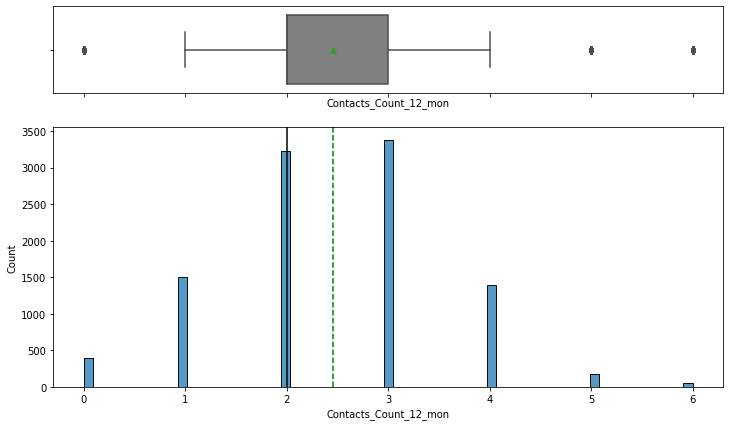

In [27]:
# draw box-plot and hitogram of numerical col
hb(df,'Contacts_Count_12_mon')

- discrete distribution with largest frequencies at 2 & 3, and least at 6

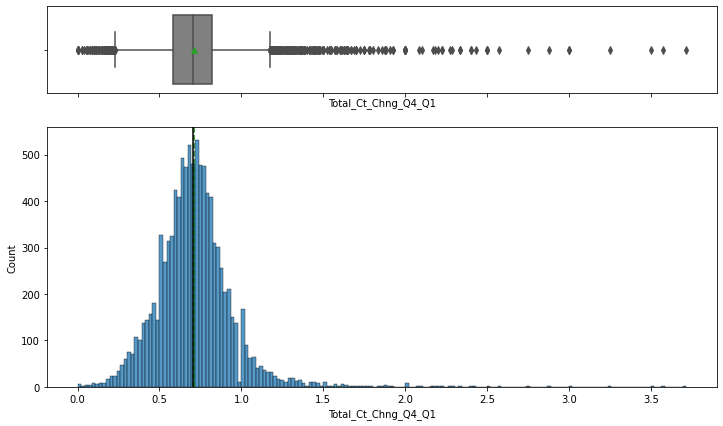

In [28]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Ct_Chng_Q4_Q1')

- a somewhat symmetic distribution with a long tail to the right

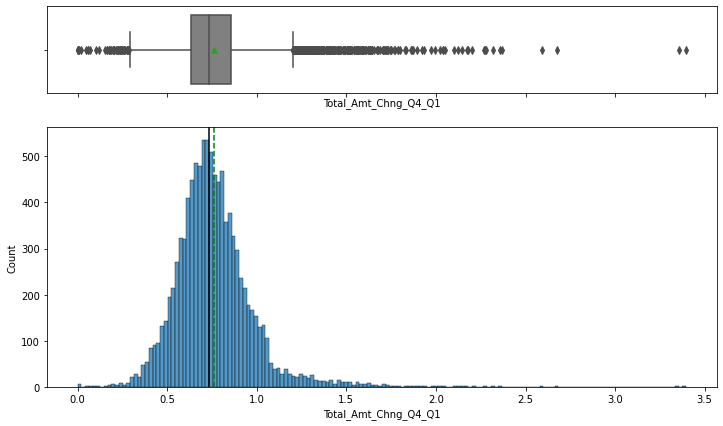

In [29]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Amt_Chng_Q4_Q1')

- pretty similar distribution to 'Total_Ct_Chng_Q4_Q1', a somewhat symmetic distribution, though with a long tail to the right
- should be checked further whether one of them is un-necessary

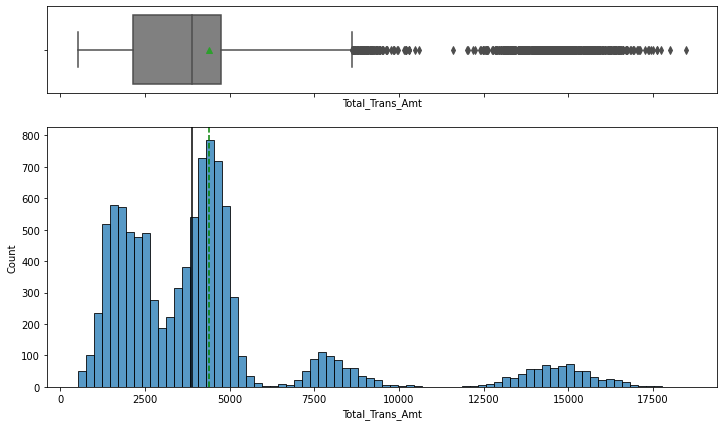

In [30]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Trans_Amt')


- right skewed distribution with outliers to the right
- scaling is needed since values are in thousands, and some other numerical features are in fractions or small integers

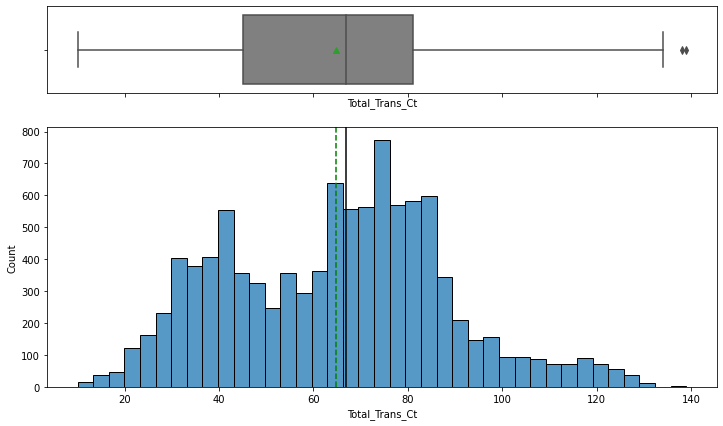

In [31]:
# draw box-plot and hitogram of numerical col
hb(df,'Total_Trans_Ct')

- somewhat symmertric distribution with a few outliers on the right

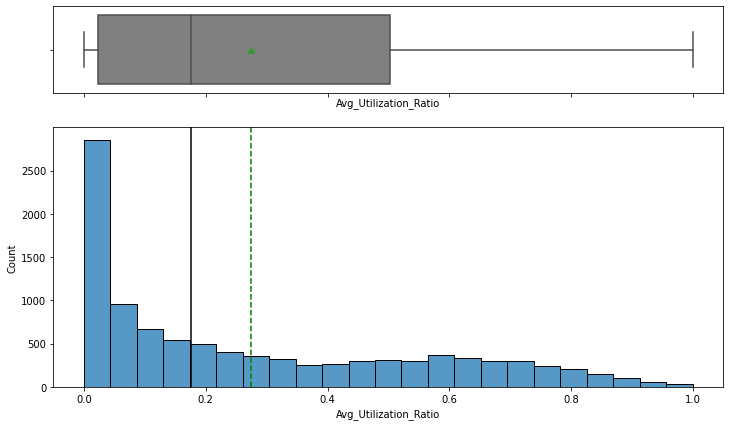

In [32]:
# draw box-plot and hitogram of numerical col
hb(df,'Avg_Utilization_Ratio')

- a right skewed distribution with values ranging between [0,1]. highest concentration near 0, and least around 1.0 though

# Bivariate & Multivariate Analysis

In [33]:
# still there are just too many numerical columns, let's divide full numerical cols into 2 
# and plot pairplot for each to understand pairplot better
first_set = ['Customer_Age','Months_on_book' ,'Credit_Limit', 'Avg_Open_To_Buy', 
             'Total_Amt_Chng_Q4_Q1' , 'Total_Ct_Chng_Q4_Q1','Total_Relationship_Count' ,'Attrition_Flag']
df_first_set = df[first_set]

# and now for the second set
num_cols = df.select_dtypes(include = np.number).columns.to_list()
second_set =  [cols for cols in num_cols if cols not in first_set]
second_set.append('Attrition_Flag')  # add Attrition_Flag to second_set

df_second_set = df[second_set]

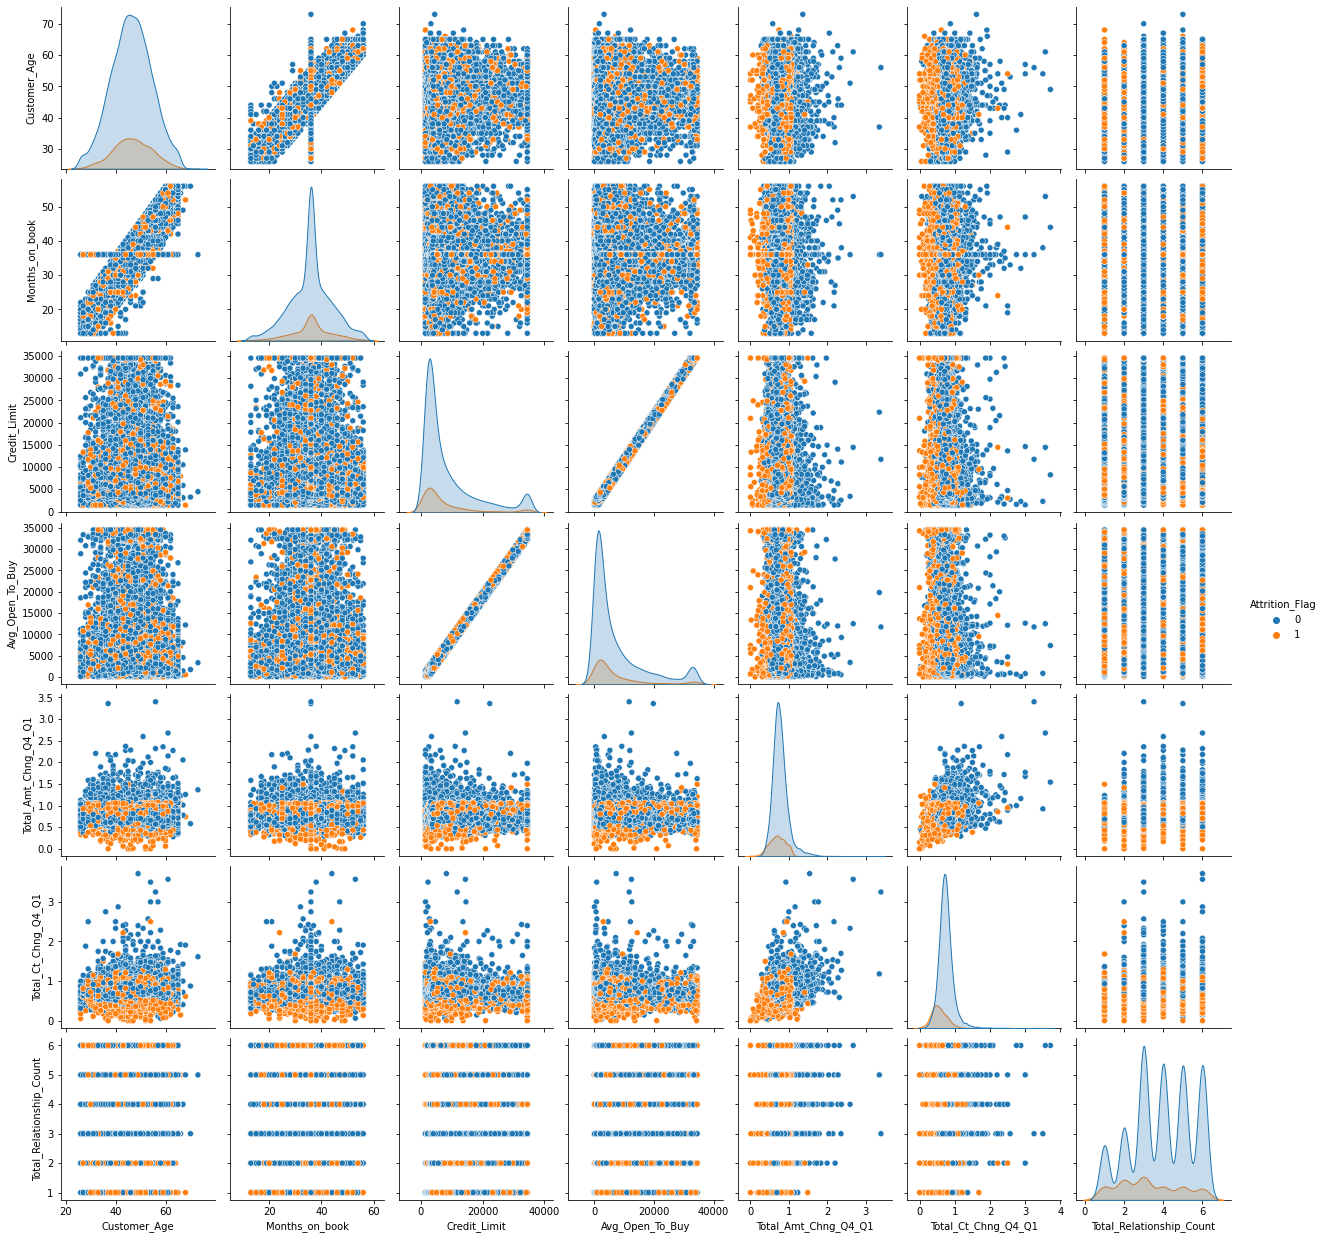

In [34]:
sns.pairplot(df_first_set, hue = 'Attrition_Flag')

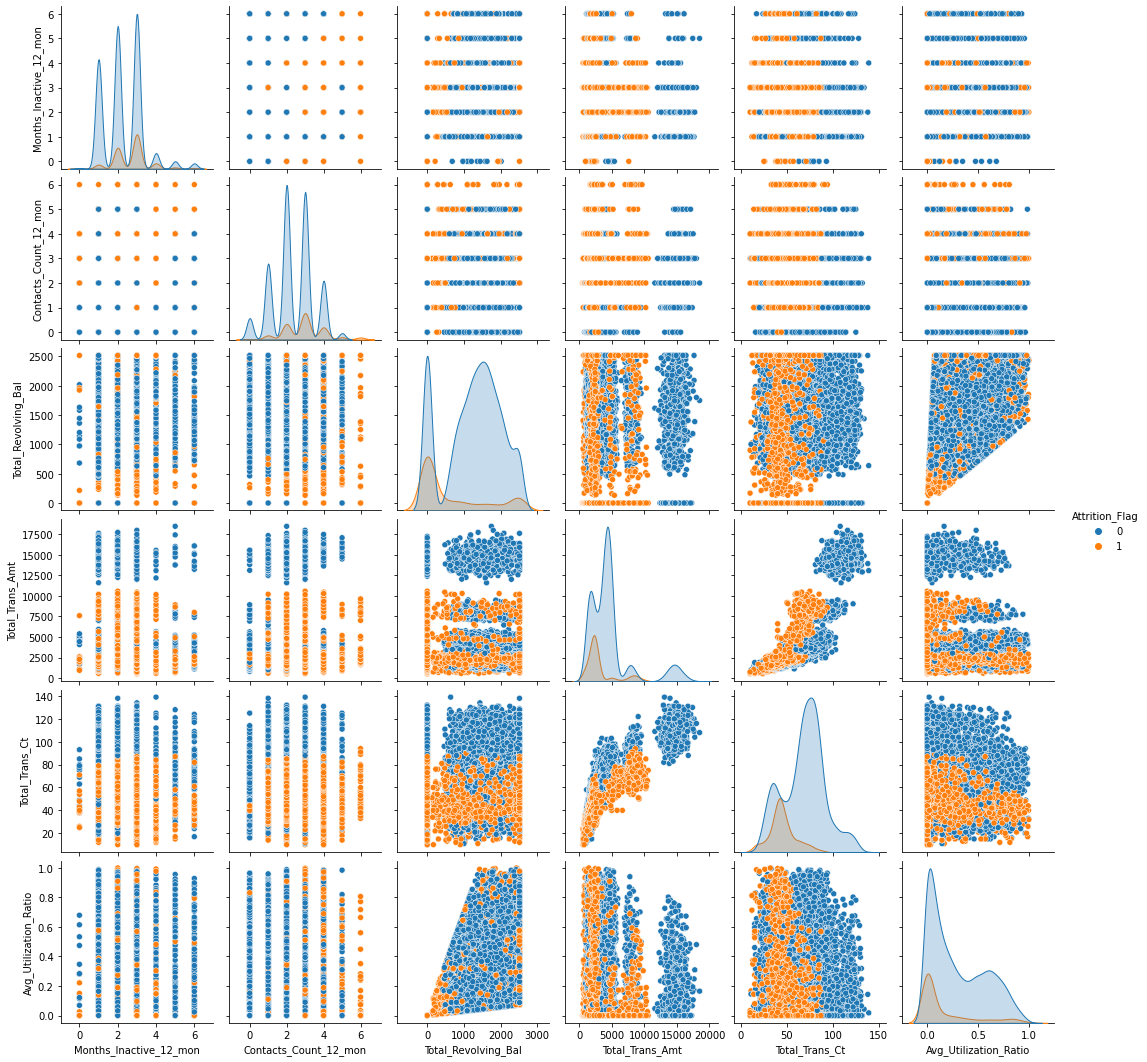

In [35]:
# now lets pairplot the second set
sns.pairplot(df_second_set, hue = 'Attrition_Flag')

#### Observations from pairplot (Overall)
- The values of Customer_Age is perfectly overlapping for different classes of Attrition_Flag - 
    - customer_Age maynot be a good predictor of our classification classes 
        - to be observed more
- Months_On_book, Credit_Limit,Avg_Open_to_buy are also overlapping for different classes of Attrition_Flag
    - those columns to be observed more since they may also not be a good predictor of our classification classes
- Credit_Limit and Avg_Open_to_buy look perfectly linearly correlated
- There are some gaps in Total_AMt_Chng_Q4_Q1 and Total_CT_Chng_Q4_Q1 for different classes of Attrition_Flag
- There also gaps in Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct,Total_Utilization_Ratio for different classes of Attrition_Flag
    - however, there seems to be some linear correlation between Total_Trans_Amt, Total_Trans_Ct

<AxesSubplot:>

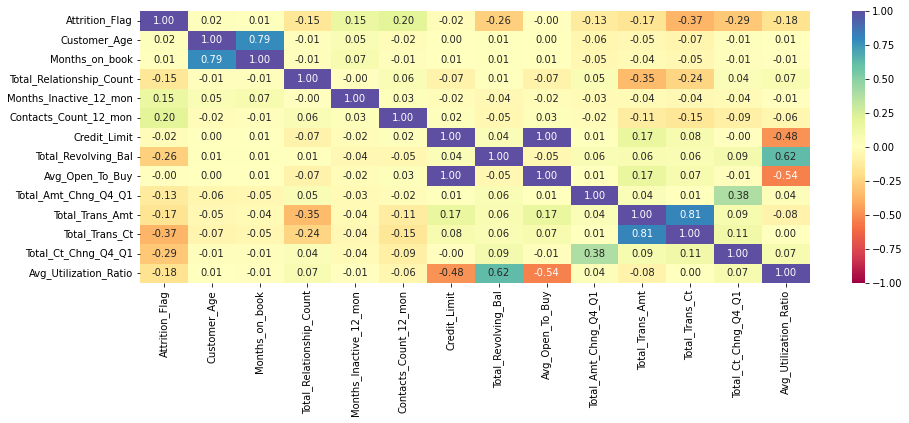

In [36]:
# and let's plot correlation plot (heatmap) to check linear correlation, if any between variables
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), annot = True, fmt = ".2f", vmin = -1, vmax = 1, cmap = "Spectral")

### Observations from correlation heatmap
#### Cases of multicollinearity
- Overall we can find many cases of multicollinearity amongst independent features in this dataset
    - this is definitely a concern for LogisticRegression Classifier which we will experiment with in this case, though not as much so for DecisionTree based classifiers which we shall also experiment with in this case
- Customer_Age and Months_on_book are highly linearly correlated (0.79)
    - we shall drop Months_On_book
- Credit_Limit and Avg_Open_To_Buy have perfect correlation (correlation 1.0)
    - we shall drop Avg_Open_To_Buy
- Avg_Utilization_Ratio also has high correlation with Total_Revolving_Bal (0.62), Avg_Open_to_Buy (0.54) and Credit_Limit (0.48)
    - we shal drop Avg_Utilization_Ratio
- Total_Trans_Amt and Total_Trans_Ct are highly correlated (0.81)
    - we shall drop Total_Trans_Amt (since Total_Trans_Ct has higher correlation with dependent variable Attrition_Flag )
- Total_Ct_Chng_Q4_Q1 and Total_Amt_Chng_Q4_Q1 are also correlated (0.38)
    - but we shall not drop any column in this case for this correlation value 

## Stacked bar plot for categorical - categorical (with against the dependent feature)

Attrition_Flag     0     1    All
Gender                           
All             8500  1627  10127
F               4428   930   5358
M               4072   697   4769
------------------------------------------------------------------------------------------------------------------------


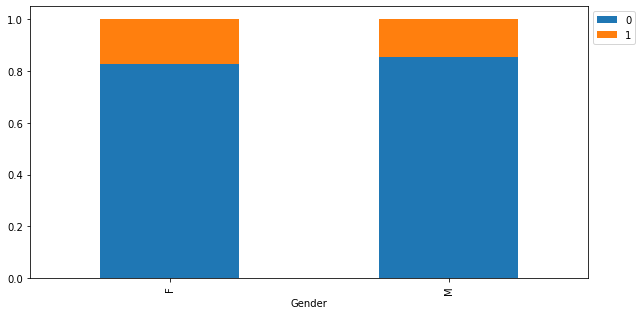

In [37]:

sb(df,'Gender', 'Attrition_Flag')

- Female tend to churn only slightly more than male

Attrition_Flag      0     1    All
Dependent_count                   
All              8500  1627  10127
3                2250   482   2732
2                2238   417   2655
1                1569   269   1838
4                1314   260   1574
0                 769   135    904
5                 360    64    424
------------------------------------------------------------------------------------------------------------------------


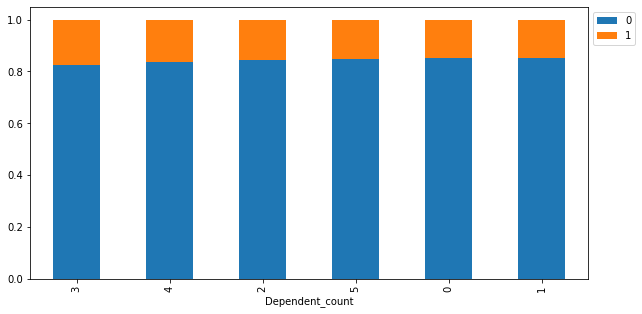

In [38]:
sb(df,'Dependent_count', 'Attrition_Flag')

- All values have similar behavior with all possible classes of target feature. Dependent_count doesnt seem to be a good preditor of Attrition_Flag

Attrition_Flag               0     1    All
Total_Relationship_Count                   
All                       8500  1627  10127
3                         1905   400   2305
2                          897   346   1243
1                          677   233    910
5                         1664   227   1891
4                         1687   225   1912
6                         1670   196   1866
------------------------------------------------------------------------------------------------------------------------


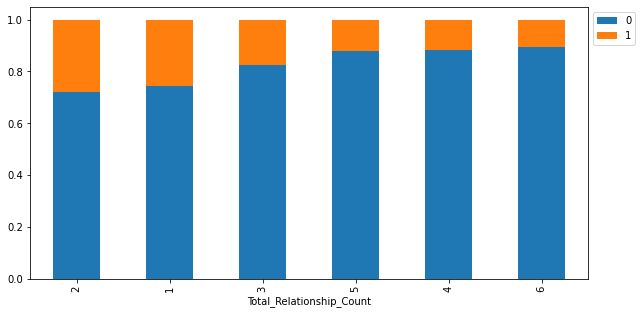

In [39]:
sb(df,'Total_Relationship_Count','Attrition_Flag')

- Total_Relationship_Count seems to be a good predictor of Attrition_Flag

Attrition_Flag      0     1    All
Income_Category                   
All              8500  1627  10127
Less than $40K   2949   612   3561
$40K - $60K      1519   271   1790
$80K - $120K     1293   242   1535
$60K - $80K      1213   189   1402
abc               925   187   1112
$120K +           601   126    727
------------------------------------------------------------------------------------------------------------------------


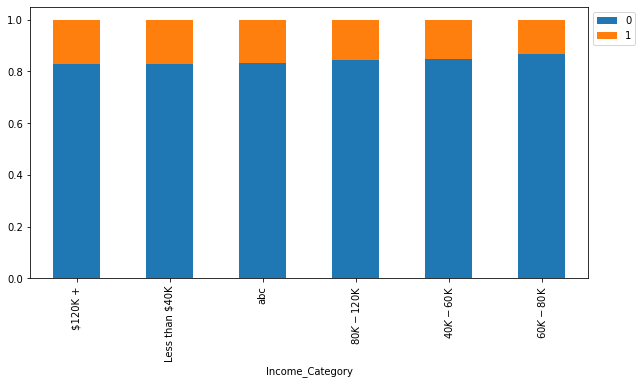

In [40]:
sb(df,'Income_Category', 'Attrition_Flag')

- Income_Category also doesn't seem to have good predicting power on the dependent variable

Attrition_Flag      0     1   All
Education_Level                  
All              7237  1371  8608
Graduate         2641   487  3128
High School      1707   306  2013
Uneducated       1250   237  1487
College           859   154  1013
Doctorate         356    95   451
Post-Graduate     424    92   516
------------------------------------------------------------------------------------------------------------------------


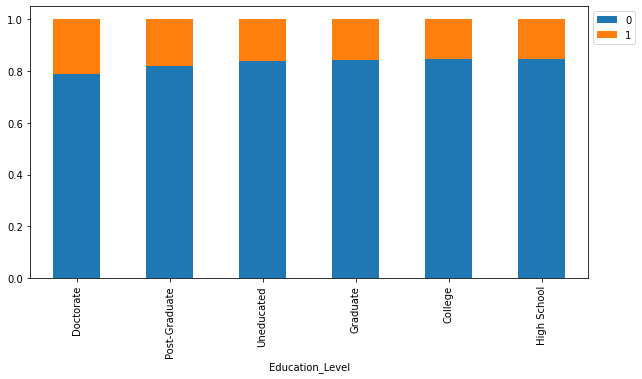

In [41]:
sb(df,'Education_Level', 'Attrition_Flag')

- Doctorate and Post-Graduate have more general tendency to attrite

Attrition_Flag     0     1   All
Marital_Status                  
All             7880  1498  9378
Married         3978   709  4687
Single          3275   668  3943
Divorced         627   121   748
------------------------------------------------------------------------------------------------------------------------


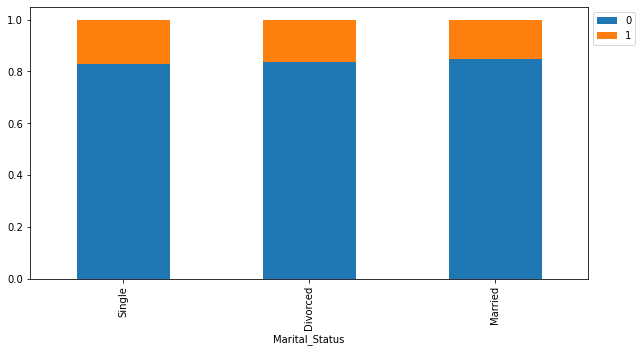

In [42]:
sb(df,'Marital_Status', 'Attrition_Flag')

- Marital_Status doesnt seem to have too much predicting power on dependent feature

Attrition_Flag     0     1    All
Card_Category                    
All             8500  1627  10127
Blue            7917  1519   9436
Silver           473    82    555
Gold              95    21    116
Platinum          15     5     20
------------------------------------------------------------------------------------------------------------------------


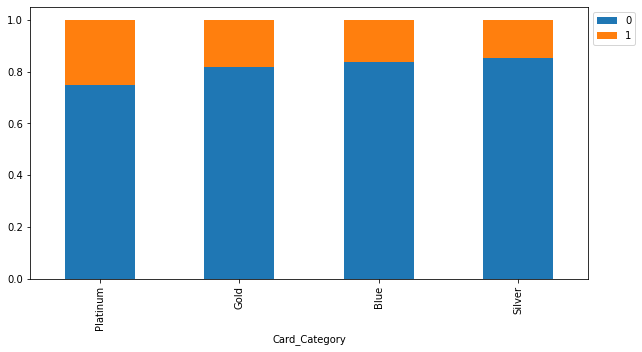

In [43]:
sb(df,'Card_Category', 'Attrition_Flag')

- Platinum category holders tend to churn more

#### Observation from Stacked barplot against dependent variable
- Dependent_Count, Income_Category, and Marital_Status don't seem to have any predicting power and we shall remove them

### Boxplot for categorical-numerical cols

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Total_Trans_Ct'>

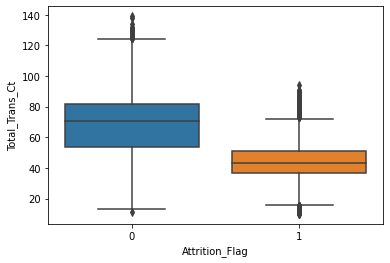

In [44]:
sns.boxplot(x = 'Attrition_Flag', y = 'Total_Trans_Ct', data = df)

- Total_Trans_Ct differentiates well to different classes of dependent variable, it might be a good predictor
- Genereally customers who attrite have fewer Total_Trans_Ct

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Total_Revolving_Bal'>

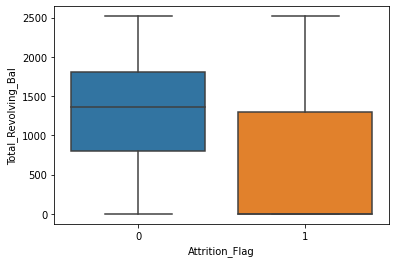

In [45]:
sns.boxplot(x = 'Attrition_Flag', y = 'Total_Revolving_Bal', data = df)

- Total_Revolving_Bal also differentiates well to different classes of dependent variable, it might also be a good predictor 
- Genereally customers who attrite have fewer Total_Revolving_Bal

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Credit_Limit'>

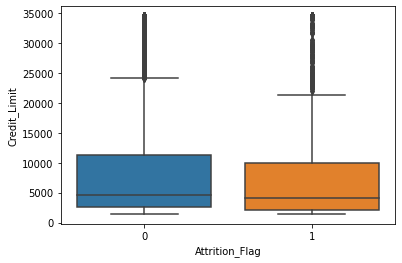

In [46]:
sns.boxplot(x = 'Attrition_Flag', y = 'Credit_Limit', data = df)

- Credit_Limit has pretty similar behavior for both classes, from the graph it seems customers who attrite generally have lower credit_limit

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Total_Ct_Chng_Q4_Q1'>

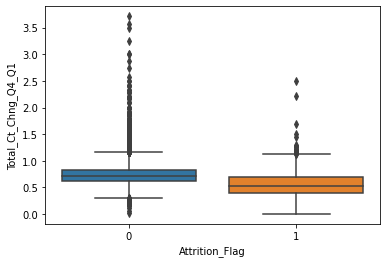

In [47]:
sns.boxplot(x = 'Attrition_Flag', y = 'Total_Ct_Chng_Q4_Q1', data = df)

- Generally people who attrite have lower Total_Ct_Chng_Q4_Q1
- It may also be a predictor since it differentiates to different classes of dependent variable

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Contacts_Count_12_mon'>

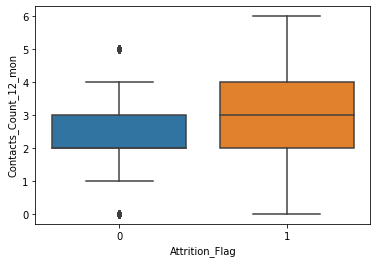

In [48]:
sns.boxplot(x = 'Attrition_Flag', y = 'Contacts_Count_12_mon', data = df)

- this feature also differentaites well to the dependent feature, it can be a good predictor
- People who attrite generally have more Contacts_Count_12_mon

## Data Preparation and Feature Engineering

In [49]:
# let's start with a fresh copy
# and we shall apply all what we've done as pre-processing and what we've learnt from EDA (cols to drop, to scale, to Onehot encode, etc )
df = data.copy()

In [50]:
X = df.drop(['Attrition_Flag'], axis=1)
y = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1 })

In [51]:
# Splitting data into training, validation and test sets:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 20) (2026, 20) (2026, 20)


In [52]:
# delete columns we found out from EDA for all:  Train, Val, and Test
cols_to_drop = ['CLIENTNUM'   # since this is ID kind of column
          ,'Months_on_book','Avg_Open_To_Buy','Avg_Utilization_Ratio','Total_Trans_Amt' # from correlation 
         ,'Dependent_count', 'Income_Category', 'Marital_Status'   # from Stacked plot(bivariate analysis with dependent variable)
         ]
X_train = X_train.drop(cols_to_drop, axis = 1)
X_val = X_val.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

In [53]:
# check the shape and dtypes of new X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 800 to 4035
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              6075 non-null   int64  
 1   Gender                    6075 non-null   object 
 2   Education_Level           5147 non-null   object 
 3   Card_Category             6075 non-null   object 
 4   Total_Relationship_Count  6075 non-null   int64  
 5   Months_Inactive_12_mon    6075 non-null   int64  
 6   Contacts_Count_12_mon     6075 non-null   int64  
 7   Credit_Limit              6075 non-null   float64
 8   Total_Revolving_Bal       6075 non-null   int64  
 9   Total_Amt_Chng_Q4_Q1      6075 non-null   float64
 10  Total_Trans_Ct            6075 non-null   int64  
 11  Total_Ct_Chng_Q4_Q1       6075 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 617.0+ KB


In [54]:
# we shall now apply SKlearns methods for imputation and scaling, since the idea is to utilize SKlearn's
# methods as much as possible so that we can automate those using Pipelines later for production deployment
# let's first extract the numerical & categorical cols
num_cols = X_train.select_dtypes(include = np.number).columns.to_list()
cat_cols = X_train.select_dtypes(exclude = np.number).columns.to_list()
#print(num_cols)
#print(cat_cols)

In [55]:
# Standard Scaler on Numerical Cols

SC = StandardScaler()

X_train[num_cols] = SC.fit_transform(X_train[num_cols])  # fit only on Train set,
X_val[num_cols] = SC.transform(X_val[num_cols])   # only transform on Val, to ensure no leakage
X_test[num_cols] = SC.transform(X_test[num_cols]) # only transform on Test, to ensure no leakage



In [56]:
# Simple Imputer on Categorical cols, with strategy = 'most_frequent'

SI = SimpleImputer(strategy = 'most_frequent')
X_train[cat_cols] = SI.fit_transform(X_train[cat_cols]) # fit only on Train set,
X_val[cat_cols] = SI.transform(X_val[cat_cols])   # only transform on Val, to ensure no leakage
X_test[cat_cols] = SI.transform(X_test[cat_cols])  # only transform on Test, to ensure no leakage

In [57]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train)
X_val = pd.get_dummies(data=X_val)
X_test = pd.get_dummies(data=X_test)

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 800 to 4035
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer_Age                   6075 non-null   float64
 1   Total_Relationship_Count       6075 non-null   float64
 2   Months_Inactive_12_mon         6075 non-null   float64
 3   Contacts_Count_12_mon          6075 non-null   float64
 4   Credit_Limit                   6075 non-null   float64
 5   Total_Revolving_Bal            6075 non-null   float64
 6   Total_Amt_Chng_Q4_Q1           6075 non-null   float64
 7   Total_Trans_Ct                 6075 non-null   float64
 8   Total_Ct_Chng_Q4_Q1            6075 non-null   float64
 9   Gender_F                       6075 non-null   uint8  
 10  Gender_M                       6075 non-null   uint8  
 11  Education_Level_College        6075 non-null   uint8  
 12  Education_Level_Doctorate      6075 non-null  

# Model Building

First we will build the following 7 estimators with default paramters and utilizing a cross_validation of 5 folds on our selected evaluation criterion

1. LogisticRegression
2. DecisionTreeClassifier
3. BaggingClassifier(
4. RandomForestClassifier
5. GradientBoostingClassifier
6. AdaBoostClassifier
7. XGBClassifier



### Model evaluation criteria

As per our data, the dependent feature (y)
- 1 - as customers who would churn or attrite;
- 0 - as customers who wouldn't churn or attrite

Thera Bank simultaneously wants to maximize predictions for TP (predict people who would churn - so that they can hopefully proactively take some actions), while minimizing FN (wrong prediction that customers wouldn't churn, but they churned) 

Of course, business would lose some resource in case of FP, but that loss is comparitively much lesser than churning customers

Therefore, we would use Recall as the Scoring Metrics

In [59]:
## let's first create functions to measure performance of classification models
## Function to create confusion matrix
def conf_mat(model, X_test, y_test):
    
    pred_test =  model.predict(X_test)
    cf = confusion_matrix(y_test, pred_test)
    categories = ['Zero', 'One']
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,6))
    sns.heatmap(cf, annot=labels, fmt=''
            ,xticklabels = categories
            ,yticklabels = categories
            ,cmap='Blues' 
           )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')


def model_performance(model, predictors, target):

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

 # Model building - Imbalanced Data

In [60]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("log", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))


results = [] ;names = []; score = []


print("\n" "Imbalanced Train without OverSampling/ UnderSampling: Cross-Validation Score:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Score on model trained on Imbalanced Train" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))
    


Imbalanced Train without OverSampling/ UnderSampling: Cross-Validation Score:

log: 0.5174515960230246
dtree: 0.6424437467294609
Bagging: 0.6424071166928309
Random forest: 0.6331920460491889
GBM: 0.6823809523809524
Adaboost: 0.6998063840920984
Xgboost: 0.718226059654631

Validation Score on model trained on Imbalanced Train

log: 0.5644171779141104
dtree: 0.6533742331288344
Bagging: 0.6748466257668712
Random forest: 0.7147239263803681
GBM: 0.7208588957055214
Adaboost: 0.7392638036809815
Xgboost: 0.7699386503067485


### Observation on Recall score on model fitted with Imbalanced Train data
- XGBoost gives best Recall in Train & Val - 0.72 vs 0.77 (slightly overfitted though)
- AdaBoost comes after XGBoost - 0.7 vs 0.74 in Train & Val

# Model building - Oversampled data

### SMOTE for Oversampling

In [61]:
# using K_neigbors = 5
sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print(X_train_over.shape,y_train_over.shape )


(10198, 21) (10198,)


In [62]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("log_over", LogisticRegression(random_state=1)))
models.append(("dtree_over", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging_over", BaggingClassifier(random_state=1)))
models.append(("Random forest_over", RandomForestClassifier(random_state=1)))
models.append(("GBM_over", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost_over", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost_over", XGBClassifier(random_state=1, eval_metric="logloss")))


results = [] ;names = []; score = []


print("\n" "OverSampled Train: Cross-Validation Score:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Score with model trained on Oversampled Train:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))
    


OverSampled Train: Cross-Validation Score:

log_over: 0.8627220073505357
dtree_over: 0.9242979468529315
Bagging_over: 0.9343004483442051
Random forest_over: 0.9609740422174757
GBM_over: 0.944501529758125
Adaboost_over: 0.9250874559833747
Xgboost_over: 0.9574438607631472

Validation Score with model trained on Oversampled Train:

log_over: 0.7883435582822086
dtree_over: 0.7208588957055214
Bagging_over: 0.7208588957055214
Random forest_over: 0.7730061349693251
GBM_over: 0.8190184049079755
Adaboost_over: 0.8159509202453987
Xgboost_over: 0.7791411042944786


### Observation on Recall score on model fitted with Oversampled Train
- logisticregression has really improved the recall on both oversampled train and Val - 086 to 0.79. still overfit though
- However, other decision tree based estimators are now very overfitting'


# Model building - Undersampled data

### RandomSampler for undersampled data

In [63]:
# fit a RandomUnderSample to X_train, y_train
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

models = []  # Empty list to store all the models

# fit 7 classifier estimators with 5 fold cross validated recall as scoring
models.append(("log_under", LogisticRegression(random_state=1)))
models.append(("dtree_under", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging_under", BaggingClassifier(random_state=1)))
models.append(("Random forest_under", RandomForestClassifier(random_state=1)))
models.append(("GBM_under", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost_under", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost_under", XGBClassifier(random_state=1, eval_metric="logloss")))


results = [] ;names = []; score = []


print("\n" "Undersampled Train: Cross-Validation Score:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Score with model trained on Undersampled Train:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Undersampled Train: Cross-Validation Score:

log_under: 0.8104761904761905
dtree_under: 0.8156096284667711
Bagging_under: 0.8340240711669283
Random forest_under: 0.8678388278388279
GBM_under: 0.8791156462585035
Adaboost_under: 0.8658503401360544
Xgboost_under: 0.8811773940345369

Validation Score with model trained on Undersampled Train:

log_under: 0.8374233128834356
dtree_under: 0.8466257668711656
Bagging_under: 0.8496932515337423
Random forest_under: 0.8834355828220859
GBM_under: 0.8865030674846626
Adaboost_under: 0.8865030674846626
Xgboost_under: 0.9141104294478528


### Observation on Recall score on model fitted with Undersampled Train
- almost all the models now genralize well
- also for almost all the models the absolute recall value is also very goood, both in train and validation
- XGBoost gives the best model in this case with 0.88 and 0.91 recall scores in train & validation

In [64]:
# Now lets create a dataframe for all the result that we've until now
# we shall also use that for comparision

compare = pd.DataFrame({ 'Train_without':[0.517,0.642,0.642,0.633,0.682,0.7,0.718]
,'Val_without':[0.564,0.653,0.675,0.715,0.721,0.739,0.77]
,'Train_over':[0.863,0.924,0.934,0.961,0.945,0.925,0.957]
,'Val_over':[0.788,0.721,0.721,0.773,0.819,0.816,0.779]
,'Train_under':[0.81,0.816,0.834,0.868,0.879,0.866,0.881]
,'Val_under':[0.837,0.847,0.85,0.883,0.887,0.887,0.914]
}, index = ['log',
'dtree',
'Bagging',
'Random forest',
'GBM',
'Adaboost',
'Xgboost']
)


In [65]:
print('Recall Score Comparision with Imbalanced, oversampling, and undersampling')
compare

Recall Score Comparision with Imbalanced, oversampling, and undersampling


,Train_without,Val_without,Train_over,Val_over,Train_under,Val_under
log,0.52,0.56,0.86,0.79,0.81,0.84
dtree,0.64,0.65,0.92,0.72,0.82,0.85
Bagging,0.64,0.68,0.93,0.72,0.83,0.85
Random forest,0.63,0.71,0.96,0.77,0.87,0.88
GBM,0.68,0.72,0.94,0.82,0.88,0.89
Adaboost,0.70,0.74,0.93,0.82,0.87,0.89
Xgboost,0.72,0.77,0.96,0.78,0.88,0.91


## Model comparision from imbalanced, Oversampling, and undersampling
- We can see all decision tree based estimators overfitted in oversampling
- LogisticRegression underfitted in imbalanced training data
- The best models for each case
 - Train_without (imbalanced) - XGBoost
 - Train_over (with oversampling) - Adaboost
 - Train_under (with undersampling) - XGBoost
 
 Since we're asked to choose 3 best models, we'll also include RandomForest, so our selected models are:
- 1. RandomForest
- 2. AdaBoost
- 3. XGBoost

# Hyperparameter tuning using RandomizedSearchCV

In [66]:
# first let's start with Random Forest

rf_estimator_tuned = RandomForestClassifier(random_state=1, n_jobs = -1)

# Grid of parameters to choose from
## add from article
parameters = {"n_estimators": [150,200,250],
    "max_depth": np.arange(1,6),
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
rand_obj =RandomizedSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
rand_obj = rand_obj.fit(X_train, y_train)

rf_h = rand_obj.best_estimator_

# Fit the best algorithm to the data.
rf_h.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.5000000000000001,
                       max_samples=0.5, min_samples_leaf=6, n_estimators=250,
                       n_jobs=-1, random_state=1)

Test performance (Scores & Conf Mat) by Hyperparameter tuned RandomForest
**************************************************


,Accuracy,Recall,Precision,F1
0,0.91,0.58,0.82,0.68


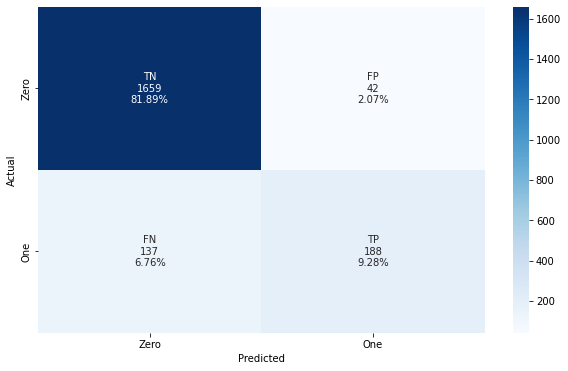

In [67]:
# Calculating different metrics on validation set
rf_tuned_model_test_perf = model_performance(
    rf_h, X_test, y_test
)
print("Test performance (Scores & Conf Mat) by Hyperparameter tuned RandomForest")
print('*'*50)
display(rf_tuned_model_test_perf)

conf_mat(rf_h,X_test, y_test )



<AxesSubplot:>

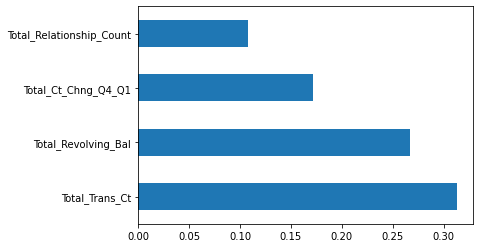

In [68]:
# see the feature importance of  hypertuned RandomForest model
pd.Series(rf_h.feature_importances_, index=X_train.columns).nlargest(4).plot(kind='barh')

In [69]:
# now we'll apply RandomizedSearchCV on AdaBoost

abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
rand_obj = RandomizedSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
rand_obj = rand_obj.fit(X_train, y_train)

abc_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5000000000000002, n_estimators=40,
                   random_state=1)

Test performance (Scores & Conf Mat) by Hyperparameter tuned ADAboost
**************************************************


,Accuracy,Recall,Precision,F1
0,0.93,0.74,0.82,0.78


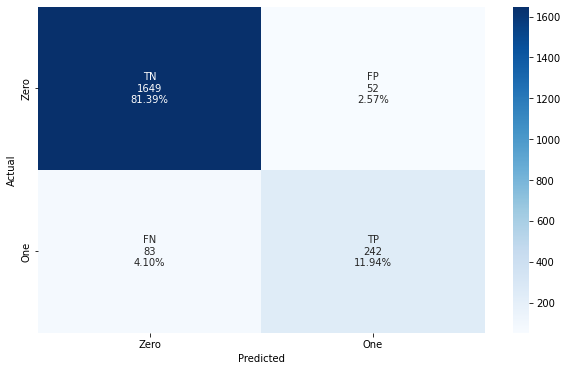

In [70]:
# displaying scores on test and confusion matrix
abc_tuned_model_test_perf = model_performance(
    abc_tuned, X_test, y_test
)
print("Test performance (Scores & Conf Mat) by Hyperparameter tuned ADAboost")
print('*'*50)
display(abc_tuned_model_test_perf)

conf_mat(abc_tuned,X_test, y_test )


<AxesSubplot:>

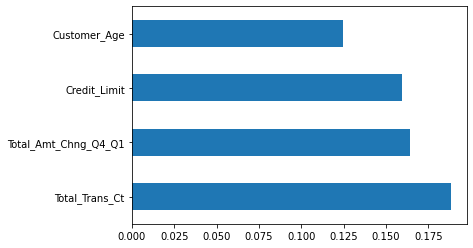

In [71]:
# see the feature importance of  hypertuned AdaBoost model
pd.Series(abc_tuned.feature_importances_, index=X_train.columns).nlargest(4).plot(kind='barh')

In [72]:
# now we'll apply RandomizedSearchCV on XGBoost
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss', n_jobs = -1)

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(50,100,10),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
rand_obj = RandomizedSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
rand_obj = rand_obj.fit(X_train, y_train)

xgb_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='logloss', gamma=1,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

Test performance (Scores & Conf Mat) by Hyperparameter tuned XGBoost
**************************************************


,Accuracy,Recall,Precision,F1
0,0.91,0.85,0.67,0.75


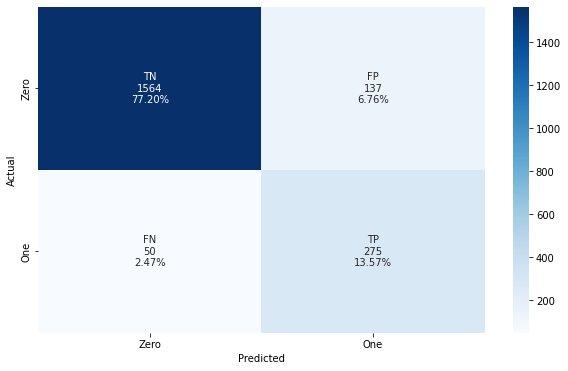

In [73]:
# displaying scores on test and confusion matrix
xgb_tuned_model_test_perf = model_performance(
    xgb_tuned, X_test, y_test
)
print("Test performance (Scores & Conf Mat) by Hyperparameter tuned XGBoost")
print('*'*50)
display(xgb_tuned_model_test_perf)

conf_mat(xgb_tuned,X_test, y_test )

<AxesSubplot:>

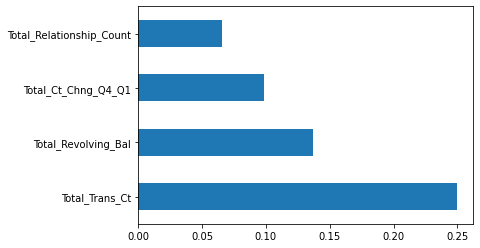

In [74]:
# see the feature importance of hypertuned XGboost model
pd.Series(xgb_tuned.feature_importances_, index=X_train.columns).nlargest(4).plot(kind='barh')

## Model Performances

### Comparing Recall, but also other metrics (Accuracy, Precision, FI) on Test for our hypertuned models

In [75]:
# let's combine all results in one dataframe for comparision
result = pd.concat([rf_tuned_model_test_perf,
abc_tuned_model_test_perf,
xgb_tuned_model_test_perf], ignore_index=True)

result = result.rename(index = {0: 'RandomForest', 1: 'Adaboost', 2: 'XGBoost'})
result

,Accuracy,Recall,Precision,F1
RandomForest,0.91,0.58,0.82,0.68
Adaboost,0.93,0.74,0.82,0.78
XGBoost,0.91,0.85,0.67,0.75


### Observation
- Based on the above table, we can infer XGBoost gives the best performance on Recall, and overall
- Final Model:XGBoost	with Total_Trans_Ct is the top feature affecting the model, followed by Total_Revolving_Bal and Total_Ct_Chng_Q4_Q1
- So we'll select hypertuned XGBoost for this case, but we shall still tune the XGBoost now with GridSearchCV for the best model for our case

### GridSearchCV on XGBoost to select the best model with best hyperparameter for our case

In [76]:
# now we'll apply GridSearchCV on XGBoost
xgb_tuned_gs= XGBClassifier(random_state=1,eval_metric='logloss', n_jobs = -1, 
                            use_label_encoder=False   # to supress warning message from XGBoost
                           )

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(50,100,10),
    "scale_pos_weight":[0,5],
    "subsample":[0.7,0.9],
    "learning_rate":[0.01,0.05],
    "gamma":[0,3],
    "colsample_bytree":[0.7,1],
    "colsample_bylevel":[0.5,0.7]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
rand_obj = GridSearchCV(xgb_tuned_gs, parameters,scoring=acc_scorer,cv=5, n_jobs = -1)
rand_obj = rand_obj.fit(X_train, y_train)

xgb_tuned_gs = rand_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned_gs.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Test performance (Scores & Conf Mat) by GridSearch Hyperparameter tuned XGBoost
**************************************************


,Accuracy,Recall,Precision,F1
0,0.92,0.88,0.70,0.78


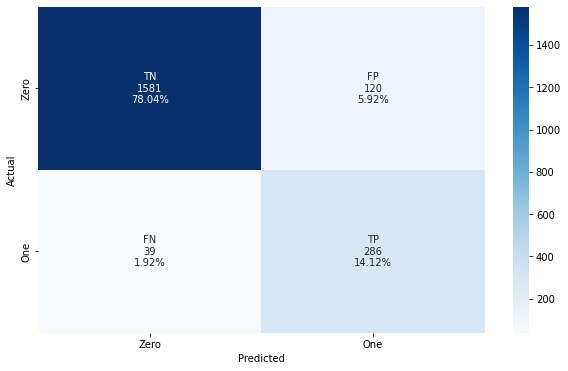

In [77]:
# displaying scores on test and confusion matrix after finding best hyperparameters using GridSearchCV
xgb_tuned_model_with_grids_test_perf = model_performance(
    xgb_tuned_gs, X_test, y_test
)
print("Test performance (Scores & Conf Mat) by GridSearch Hyperparameter tuned XGBoost")
print('*'*50)
display(xgb_tuned_model_with_grids_test_perf)

conf_mat(xgb_tuned_gs,X_test, y_test)

<AxesSubplot:>

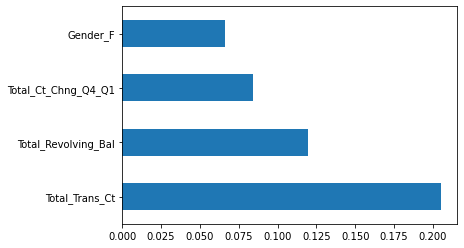

In [78]:
# see the feature importance of best hypertuned XGboost model using GridSearchCV
pd.Series(xgb_tuned_gs.feature_importances_, index=X_train.columns).nlargest(4).plot(kind='barh')

### Final Model : XGboost with below Hyperparameters

- So we'll select hypertuned XGBoost for this case with below hyperparameters
- Total_Trans_Ct is the top feature affecting the model, followed by Total_Revolving_Bal and Total_Ct_Chng_Q4_Q1
- XGBClassifier(
              random_state=1,
              n_estimators=50,
              colsample_bylevel=0.7,
              colsample_bytree=1, 
              eval_metric='logloss', 
              gamma=3, 
              learning_rate=0.05, 
              max_depth=6, 
              reg_alpha=0, 
              reg_lambda=1, 
              scale_pos_weight=5,
              subsample=0.7
        )

# Productionize the model using Pipelines

- Now that we've trained and found out the best model for our purpose, along with its hyper-parameters, now the effort with Pipeline is just to automate pre-processing, transform and fit. 
 Ultimately, Pipeline will be the deliverable End Product.

In [79]:
df = data.copy()
X = df.drop(['Attrition_Flag'], axis=1)
y = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1 })

In [80]:
# Splitting data into training & test sets:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(7088, 20) (3039, 20)


In [81]:
# create a list of numerical & categoricl features for pipeline
numerical_features = ['Customer_Age','Total_Relationship_Count','Months_Inactive_12_mon',
                      'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                      'Total_Amt_Chng_Q4_Q1','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1']

categorical_features = ['Gender', 'Education_Level', 'Card_Category']

# creating a transformer for numerical variables, which will apply Standard Scaler on the numerical variables
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


# creating a transformer for categorical variables, which will first apply simple imputer and
# then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combining categorical transformer and numerical transformer using a column transformer
# transformer applications are strictly defined in numerical_features list and categorical_features
# remaining columns to be dropped
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

In [82]:
# create the pipeline now to also include our XGBoost estimator with hyperparamaeters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("xgb", XGBClassifier(
              random_state=1,
              n_estimators=50,
              colsample_bylevel=0.7,
              colsample_bytree=1, 
              eval_metric='logloss', 
              gamma=3, 
              learning_rate=0.05, 
              max_depth=6, 
              reg_alpha=0, 
              reg_lambda=1, 
              scale_pos_weight=5,
              subsample=0.7
             )
        )
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Customer_Age',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1']),
                                                 ('cat',
                                     

Test performance on Pipelined XGBoost estimator
**************************************************


,Accuracy,Recall,Precision,F1
0,0.91,0.85,0.68,0.75


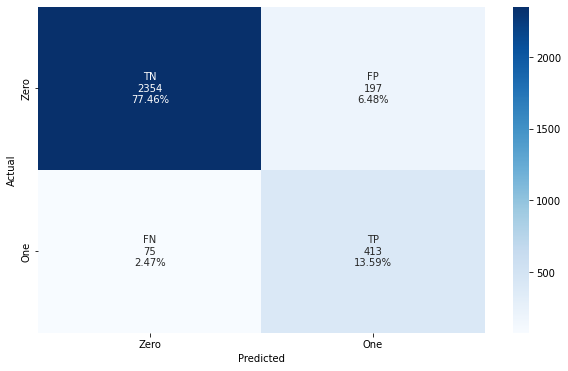

In [83]:
pipeline_test_perf = model_performance(
    model, X_test, y_test
)
print("Test performance on Pipelined XGBoost estimator")
print('*'*50)
display(pipeline_test_perf)

conf_mat(model,X_test, y_test)

## Actionable Insights & Recommendations

- For the business problem that Credit Card customers are churning fast for Thera Bank, and based on the data provided, an XGBosst based classification model is proposed to predict and classify whether ccustomers will atrrite/ churn or not
- Following is the hyperparameter of the model
XGBClassifier(
              random_state=1,
              n_estimators=50,
              colsample_bylevel=0.7,
              colsample_bytree=1, 
              eval_metric='logloss', 
              gamma=3, 
              learning_rate=0.05, 
              max_depth=6, 
              reg_alpha=0, 
              reg_lambda=1, 
              scale_pos_weight=5,
              subsample=0.7
             )
Some of the top features that affect this model are:
1. Total_Trans_Ct - This is the highest affecting feature. Generally customers who leave have low Total_Trans_Qt. Thera Bank is advised to especially follow those customers where Total_Trans_Ct is on the lower side
2. Total_Revolving_Bal - This is the second highest affecting feature. Generally customers who leave have low Total_Revolving_Bal. Thera Bank is advised to followup with customers having lower range of Total_Revolving_Bal
3. Total_Ct_Chng_Q4_Q1 - This feature also affects the customers decision. Thera Bank is recommended to followup especially with customers on lower range of Total_Ct_Chng_Q4_Q1
4. Contacts_Count_12_mon -  From data anlysis, it is found that Customers who had more Contacts_Count_12_mon churn more. Probably the customers find Thera contacts more annoying than helping/ or simply not upto the mark on their queries. Thera Bank is advised to review the quality of its contacts
5. Gender Female -  Thera Bank is advised to especially reach out to Female customers, since they churn more than Male customers generally
